# Creating the dataset for the training

---
**USEFUL LINKS :**

The paper and its github :

https://github.com/lindawangg/COVID-Net

---

In [2]:
# !pip install pydicom
!pip install "torch==1.4" "torchvision==0.5.0" # to avoid a warning spam

     |████████████████████████████████| 753.4MB 21kB/s 
     |████████████████████████████████| 4.0MB 41.1MB/s 
  Found existing installation: torch 1.5.1+cu101
    Uninstalling torch-1.5.1+cu101:
      Successfully uninstalled torch-1.5.1+cu101
  Found existing installation: torchvision 0.6.1+cu101
    Uninstalling torchvision-0.6.1+cu101:
      Successfully uninstalled torchvision-0.6.1+cu101


In [3]:
# IMPORTS :
from fastai.vision import *

import pandas as pd
import csv

from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedShuffleSplit

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Unzip CovidX-v4 dataset
!unzip -q '/content/drive/My Drive/Colab Notebooks/Internship/COVID19_DATA/Covid-X-v4.zip'

print('Done!')

file #1:  bad zipfile offset (lseek):  0
file #2:  bad zipfile offset (local header sig):  63
file #3:  bad zipfile offset (lseek):  32768


In [ ]:
# path = Path('drive/My Drive/Colab Notebooks/Internship/COVID19_DATA/covidx')

# # import pandas as pd

# df = pd.read_csv(path/'train_split_v3.txt', sep = ' ', header = None, usecols = [1, 2])
# df.head()



Old Version

In [ ]:

# path = Path('drive/My Drive/Colab Notebooks/Internship/COVID19_DATA/covidx')

# tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_rotate=None, max_warp=None, max_zoom=1.0)

# data = (ImageDataBunch.from_df(path, df=df, folder='train',fn_col=0, label_col=1)
#         .split_by_rand_pct(valid_pct = 0.2)     
#         .label_from_df() # 'train_split_v3.txt', sep=' ', header = None, fn_col=1, label_col=2
#         .transform(tfms= None, size=448)
#         .databunch(bs = 16)
#         .normalize(imagenet_stats))


New version

In [ ]:
import pathlib
path = pathlib.Path( '/content/data' )
path.ls()

bs = 64

seed = 42
np.random.seed( seed )

train_path = pathlib.Path( '/content/data/train/' )
test_path = pathlib.Path( '/content/data/test/' )

train = pd.read_csv(path/"train_split.txt", sep=' ', header=None, names=['Image','Class','Origin']).drop('Origin',axis=1)
test = pd.read_csv(path/"test_split.txt", sep=' ', header=None, names=['Image','Class', 'Origin']).drop('Origin',axis=1)

cv = StratifiedShuffleSplit(n_splits=2, test_size=0.1, random_state=seed)
train_idx, val_idx = next(cv.split(train['Image'],train['Class']))

data = (ImageList.from_df(train, path = train_path)
                .split_by_idxs(train_idx.tolist(), val_idx.tolist())
                .label_from_df(cols=['Class'])
                .transform(tfms=get_transforms(max_warp=0.), size=224) 
                .add_test(ImageList.from_df(test, path=test_path))
                .databunch(bs=bs, num_workers = 4)
                .normalize(imagenet_stats)
               )

['COVID-19', 'normal', 'pneumonia']


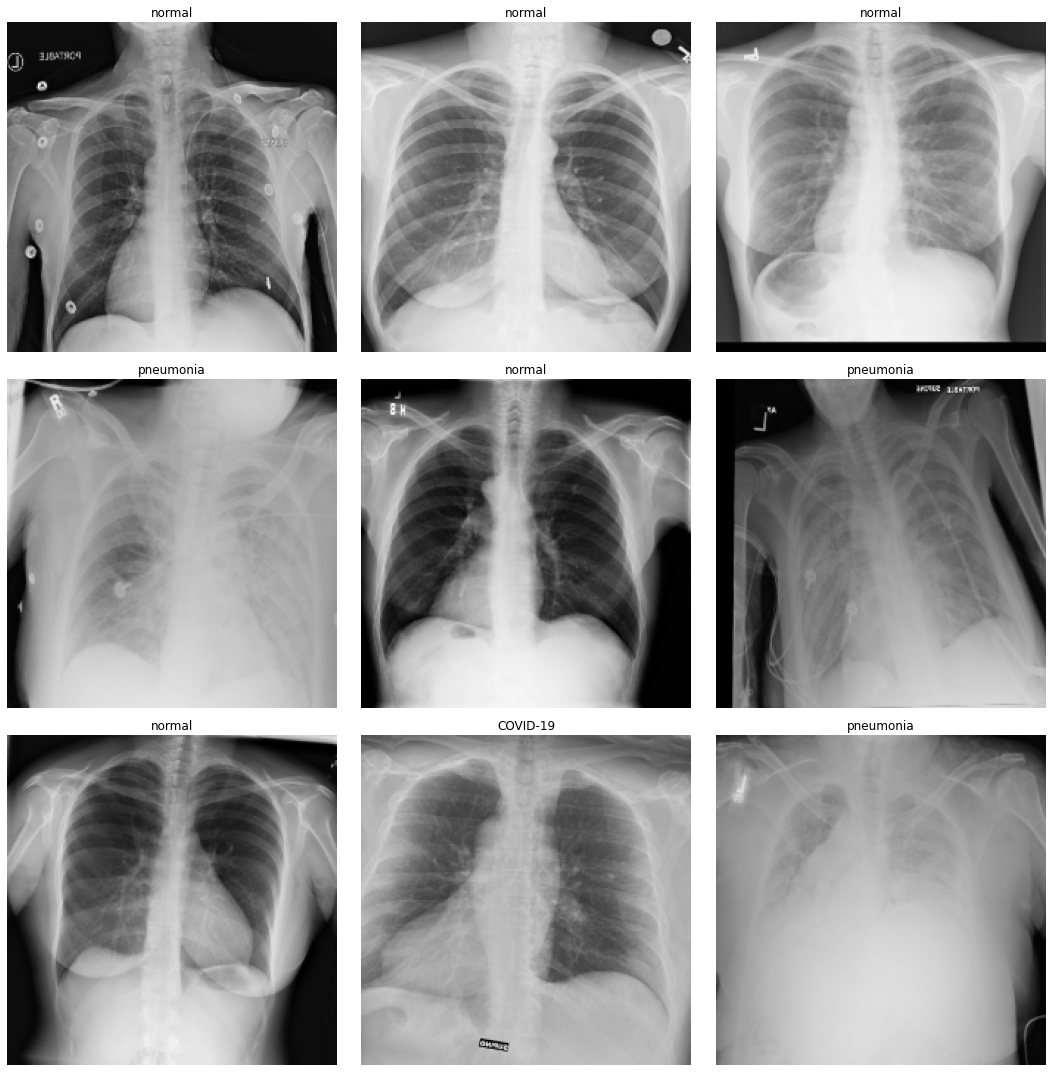

In [ ]:
print(data.classes)

data.show_batch(rows=3, figsize=(15,15))

In [ ]:
train

,Image,Class
3,SARS-10.1148rg.242035193-g04mr34g0-Fig8a-day0....,pneumonia
3,SARS-10.1148rg.242035193-g04mr34g0-Fig8b-day5....,pneumonia
3,SARS-10.1148rg.242035193-g04mr34g0-Fig8c-day10...,pneumonia
7,SARS-10.1148rg.242035193-g04mr34g04a-Fig4a-day...,pneumonia
7,SARS-10.1148rg.242035193-g04mr34g04b-Fig4b-day...,pneumonia
...,...,...
c1628c47-5ba3-42dd-8df3-7ad3abd57ad0,c1628c47-5ba3-42dd-8df3-7ad3abd57ad0.png,pneumonia
c1cddf32-b957-4753-acaa-472ab1447e86,c1cddf32-b957-4753-acaa-472ab1447e86.png,pneumonia
c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2,c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2.png,pneumonia
c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8.png,pneumonia


# Creating the model

In [ ]:
# !git clone https://github.com/sdoria/mish

In [ ]:
# %cd mish
# from mish import *
# from mxresnet import *

/content/mish
Mish activation loaded...


epoch,train_loss,valid_loss,error_rate,accuracy,precision,recall,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


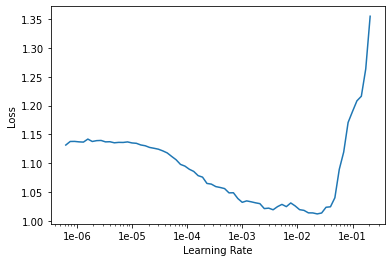

In [ ]:
from fastai.callbacks import *

mod = models.densenet169
learn = cnn_learner(data, mod, metrics=[error_rate, accuracy, Precision(), Recall()], callback_fns=[OverSamplingCallback])

# learn = Learner(data, mxresnet50(c_out=len(data.classes), sa=True), metrics=[error_rate, accuracy, Precision(), Recall()], callback_fns=[OverSamplingCallback] )

# #If we want to know the learning rate :
# learn.lr_find()
# learn.recorder.plot()

First round of learning

epoch,train_loss,valid_loss,error_rate,accuracy,precision,recall,time
0,0.528405,0.465045,0.186331,0.813669,0.728596,0.711780,15:10
1,0.355192,1.308616,0.412950,0.587050,0.646311,0.694041,14:45
2,0.266559,0.318659,0.117266,0.882734,0.758879,0.891810,14:50
3,0.197347,0.215244,0.082014,0.917986,0.917163,0.904724,14:24
4,0.160869,0.198685,0.075540,0.924460,0.946253,0.906044,14:49


/usr/local/lib/python3.6/dist-packages/fastai/metrics.py:191: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


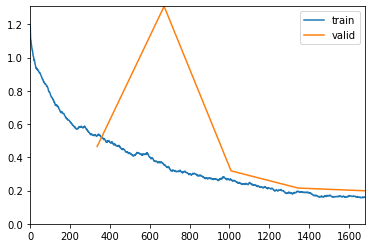

Better model found at epoch 0 with accuracy value: 0.8136690855026245.
Better model found at epoch 2 with accuracy value: 0.8827338218688965.
Better model found at epoch 3 with accuracy value: 0.9179856181144714.
Better model found at epoch 4 with accuracy value: 0.9244604110717773.


PosixPath('/content/data/train/models/mxresnet50_v3s1.pth')

In [ ]:
from fastai.callbacks import SaveModelCallback
lr = 1e-3 # using lr_find, we choose lr_max not too close from min

# Set up the learning rate (controls the step size)
learn.fit_one_cycle(8 max_lr=lr, callbacks=[ShowGraph(learn), SaveModelCallback(learn, every='improvement', monitor='accuracy',name='model')])  # epoch = number of cycle during the training : forw & backw
learn.save('densenet169_v3s1' , return_path=True)


Second round of learning

epoch,train_loss,valid_loss,error_rate,accuracy,precision,recall,time
0,0.210501,0.311139,0.120144,0.879856,0.915041,0.836472,14:45


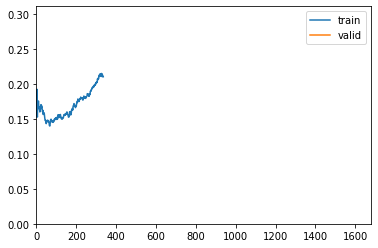

Better model found at epoch 0 with accuracy value: 0.8798561096191406.


In [ ]:
# lr2 = 1e-4

# # Set up the learning rate (controls the step size)
# learn.fit_one_cycle(5, max_lr=lr2, callbacks=[ShowGraph(learn), SaveModelCallback(learn, every='improvement', monitor='accuracy',name='model')])  # epoch = number of cycle during the training : forw & backw
# learn.save('densenet169_v2s2' , return_path=True)

Let's see some of the most incorrect images, we also compute accuracy and error rate although the ones we will use are the ones computed with the test data.

In [ ]:
# What are the most incorrect ones?
print('blabla')
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(16, figsize=(15,15)) # multi label version
# # Confusion matrix to compare the results :
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)  

probs,val_labels = learn.get_preds(ds_type=DatasetType.Valid) 
print('Accuracy',accuracy(probs,val_labels)),
print('Error Rate', error_rate(probs, val_labels))

# Show + test

Old version (issues with the number of images in the end) (???)

In [ ]:
# df_test = pd.read_csv(path/'test_split_v3.txt', sep = ' ', header = None, usecols = [1, 2])
# df_test.head()

#  data_test = (ImageDataBunch.from_df(path, df=df_test, folder='test',fn_col=0, label_col=1)
#         .split_none()    
#         .label_from_df()) 

# data_test.valid = data_test.train

# data_test = (data_test.transform(tfms = None, size=448)
        # .databunch(bs = 16))
        # .normalize(imagenet_stats))

New version adapted from COVIDX-Fastai-XResNet18.ipynb


In [ ]:
data_test = (ImageList.from_df(test, path=test_path)
            .split_none()
            .label_from_df(cols=['Class'])
            .transform(tfms=None, size=224)
            )

data_test.valid = data_test.train
data_test = data_test.databunch(bs=bs, num_workers=4).normalize(imagenet_stats)

In [ ]:
# # If need to load a different model :
# mod = models.densenet169
# learn = cnn_learner(data_test, mod, metrics=[accuracy])

# learn = learn.load(Path('Densenet169_v1s2'))

learn.data.valid_dl = data_test.valid_dl

# Interpret
interp = ClassificationInterpretation.from_learner(learn)


Let's see the most incorrect images

In [ ]:
# What are the most incorrect ones?
interp.plot_top_losses(16, figsize=(15,15)) # multi label version
# # Confusion matrix to compare the results :
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)  

probs,val_labels = learn.get_preds(ds_type=DatasetType.Valid)

print('Accuracy',accuracy(probs,val_labels)),
print('Error Rate', error_rate(probs, val_labels))


Compute the recall and the Precision per class:

In [ ]:
# adapted from COVIDX-Fastai-XResNet18.ipynb
# Convert dataframe test labels to list
gt = test['Class'].tolist()

# Convert from label names to class index values (0, 1, 2)
from sklearn import preprocessing
labels = data.classes
le = preprocessing.LabelEncoder()
targets = le.fit_transform(labels)
test_preds = le.transform( gt )

# I added this:
class_guess = probs.argmax(dim=1)

# Calculate accuracy
from sklearn.metrics import accuracy_score
acc = accuracy_score( class_guess.numpy(), np.asarray( test_preds ) )
print( "Accuracy = " + str( acc ) )

# Calculate precision per class
print(data.classes)

from sklearn.metrics import precision_score
prec = precision_score( class_guess.numpy(), np.asarray( test_preds ), average=None )
print( "Precision (Positive Predictive Value) per class = " + str( prec ))

# Calculate recall per class
from sklearn.metrics import recall_score
rec = recall_score(class_guess.numpy(), np.asarray(test_preds), average=None )
print( "Recall (Sensitiviy) per class = " + str( rec ))

In [ ]:
learn.summary

# Recall, Accuracy, Precision, etc
https://fr.wikipedia.org/wiki/Pr%C3%A9cision_et_rappel

https://docs.fast.ai/metrics.html

Recall = sensitivity

Precision = Positive predictive value


